# Plot ICESat-2 ATL10 (along-track freeboard data)

When you've run icepyx_getdata.ipynb this script should plot the alongtrack freeboard (sea ice(/iceberg?) thickness above the sea surface) data you've downloaded.

In [81]:
# import packages:
import numpy as np                   # Numeric Python
import matplotlib.pyplot as plt      # Plotting routines
import h5py                          # general HDF5 reading/writing library
import rioxarray as rx               # Package to read raster data from hdf5 files
from pyproj import Transformer, CRS  # libraries to allow coordinate transforms
import glob                          # Package to locate files on disk
import os                            # File-level utilities
import re                            # regular expressions for string interpretation
import icepyx as ipx                 # Package to interact with ICESat-2 online resources
from sliderule import icesat2        # Package for online ICESat-2 processing

import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m')

In [82]:
# Prepare coordinate transformations between lat/lon and the ATL10 coordinate system
crs=CRS.from_epsg(3413)
to_xy_crs=Transformer.from_crs(crs.geodetic_crs, crs)
to_geo_crs=Transformer.from_crs(crs, crs.geodetic_crs)

The icepyx_getdata.ipynb notebook can be used to download ATL10 data into the tmp/ folder. This block opens the files and stores the freeboard in a dictionary.

In [93]:
file_xyth={}
# use the glob package to find the ATL11s that we downloaded
for file in glob.glob('/tmp/ATL10/processed_ATL10*.h5'):
    with h5py.File(file,'r') as h5f:
        try:
            lat=np.array(h5f['gt1l']['freeboard_beam_segment']['beam_freeboard']['latitude'])
            lon=np.array(h5f['gt1l']['freeboard_beam_segment']['beam_freeboard']['longitude'])
        except Exception:
            pass
        x,y = to_xy_crs.transform(lat, lon)
        file_xyth[file]={'x':x,'y':y,'lat':lat,'lon':lon, 'h':np.array(h5f['gt1l']['freeboard_beam_segment']['beam_freeboard']['beam_fb_height']), 
                         't':np.array(h5f['gt1l']['freeboard_beam_segment']['beam_freeboard']['delta_time'])}
        # read the height values
        temp=np.array(h5f['gt1l']['freeboard_beam_segment']['beam_freeboard']['beam_fb_height'])
        # identify invalid heights, and set them to NaN
        temp[temp>15]=np.NaN
        
        # store the data in a second dictionary:
        file_xyth[file]['h']=temp


Text(0.5, 1.0, 'Freeboard height')

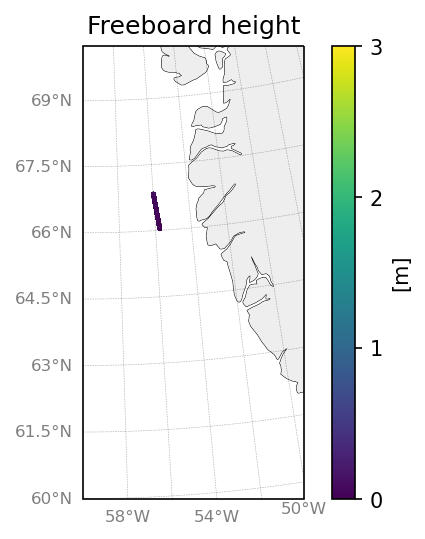

In [94]:
fig=plt.figure(dpi=150)
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-60, central_latitude=60, globe=None))
ax.coastlines(resolution='50m',linewidth=0.5)
ax.set_extent([-60,-50,60,70],crs=ccrs.PlateCarree())
# [-60,-21,-65,-50] for Antarctica

for filename, D in file_xyth.items():
    im = plt.scatter(D['lon'], D['lat'], c=D['h'], vmin=0,vmax=3, s=1, cmap='viridis',transform=ccrs.PlateCarree())
ax.add_feature(land_50m, facecolor='#eeeeee')
cbar = fig.colorbar(im, ax=ax, label='[m]',fraction=0.046, pad=0.04)
cbar.ax.locator_params(nbins=4)

gl =ax.gridlines(linewidth=0.3, draw_labels=True, color='k', alpha=0.5, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 8, 'color': 'gray'}
gl.ylabel_style = {'size': 8, 'color': 'gray'}

plt.title(f'Freeboard height')

